In [9]:
#!kaggle competitions download -c tweet-sentiment-extraction

100%|██████████████████████████████████████| 1.39M/1.39M [00:01<00:00, 1.20MB/s]
100%|██████████████████████████████████████| 1.39M/1.39M [00:01<00:00, 1.20MB/s]


In [101]:
import pandas as pd
import numpy as np
import os

import emoji

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


In [4]:
train = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/tweet-sentiment-extraction/train.csv")
test = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/tweet-sentiment-extraction/test.csv")

In [5]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


# Data exploration

## checking for null values

In [10]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [13]:
train.loc[pd.isnull(train.text)]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


## drop null

In [15]:
train.dropna(inplace=True)

## count of unique values

In [16]:
train.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [17]:
train.shape, test.shape

((27480, 4), (3534, 3))

In [45]:
train.pivot_table(index='sentiment', values='textID', 
                  aggfunc='count', margins=True)


,textID
sentiment,
negative,7781
neutral,11117
positive,8582
All,27480


In [46]:
train.pivot_table(index='sentiment', values='textID', 
                 aggfunc = lambda x: x.count()/train['sentiment'].count())


,textID
sentiment,
negative,0.283151
neutral,0.404549
positive,0.312300


# Feature engineering

## URL 

In [97]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [98]:
train['url']=train['text'].apply(lambda x:find_url(x))

In [99]:
train.loc[pd.notnull(train.url)]

,textID,text,selected_text,sentiment,url
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf
17,919fa93391,i`ve been sick for the past few days and thus...,sick,negative,http://tinyurl.com/mnf4kw
35,4f5267ad70,"Thats it, its the end. Tears for Fears vs Eric...","Thats it, its the end. Tears for Fears",neutral,http://bit.ly/2Hpbg4
50,a3ae670885,Then you should check out http://twittersucks...,Then you should check out http://twittersucks....,neutral,http://twittersucks.com
57,6086b1f016,will be back later. http://plurk.com/p/rp3k7,will be back later.,neutral,http://plurk.com/p/rp3k7
...,...,...,...,...,...
27374,b49385ebb7,"says Finally, Im home. http://plurk.com/p/rr121","says Finally, Im home.",neutral,http://plurk.com/p/rr121
27384,f94af8cb85,This is a much better tool than some I have co...,This is a much better tool,positive,http://www.tweepular.com
27386,e149ebd3a1,#vwll2009 Would one of the VWLLers want to add...,ch appreciat,positive,http://bit.ly/BF5sh
27463,a38bf809b0,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...,MISS,negative,http://bit.ly/r6RfC


## Emoticons

In [143]:
ex = "😍 lol 😆 😂 "
emoji.demojize(ex)

':smiling_face_with_heart-eyes: lol :grinning_squinting_face: :face_with_tears_of_joy: '

In [144]:
re.findall(':(.*?):', emoji.demojize(ex) )  #<-mac
#re.findall( r'\:(.*?)\:', emoji.demojize(ex) )  <- window

['smiling_face_with_heart-eyes',
 'grinning_squinting_face',
 'face_with_tears_of_joy']

In [168]:
emoji.UNICODE_EMOJI

{'🥇': ':1st_place_medal:',
 '🥈': ':2nd_place_medal:',
 '🥉': ':3rd_place_medal:',
 '🆎': ':AB_button_(blood_type):',
 '🏧': ':ATM_sign:',
 '🅰': ':A_button_(blood_type):',
 '🇦🇫': ':Afghanistan:',
 '🇦🇱': ':Albania:',
 '🇩🇿': ':Algeria:',
 '🇦🇸': ':American_Samoa:',
 '🇦🇩': ':Andorra:',
 '🇦🇴': ':Angola:',
 '🇦🇮': ':Anguilla:',
 '🇦🇶': ':Antarctica:',
 '🇦🇬': ':Antigua_&_Barbuda:',
 '♒': ':Aquarius:',
 '🇦🇷': ':Argentina:',
 '♈': ':Aries:',
 '🇦🇲': ':Armenia:',
 '🇦🇼': ':Aruba:',
 '🇦🇨': ':Ascension_Island:',
 '🇦🇺': ':Australia:',
 '🇦🇹': ':Austria:',
 '🇦🇿': ':Azerbaijan:',
 '🔙': ':BACK_arrow:',
 '🅱': ':B_button_(blood_type):',
 '🇧🇸': ':Bahamas:',
 '🇧🇭': ':Bahrain:',
 '🇧🇩': ':Bangladesh:',
 '🇧🇧': ':Barbados:',
 '🇧🇾': ':Belarus:',
 '🇧🇪': ':Belgium:',
 '🇧🇿': ':Belize:',
 '🇧🇯': ':Benin:',
 '🇧🇲': ':Bermuda:',
 '🇧🇹': ':Bhutan:',
 '🇧🇴': ':Bolivia:',
 '🇧🇦': ':Bosnia_&_Herzegovina:',
 '🇧🇼': ':Botswana:',
 '🇧🇻': ':Bouvet_Island:',
 '🇧🇷': ':Brazil:',
 '🇮🇴': ':British_Indian_Ocean_Territory:',
 '🇻🇬': ':British_Vir

In [177]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

In [194]:
extract_emojis( "😊😳😏😁")

'😊😳😏😁'

In [195]:
extract_emojis('text without emojis')

In [196]:
train['emoji']=train['text'].apply(lambda x: extract_emojis(x))

In [197]:
train.loc[pd.notnull(train.emoji)]

,textID,text,selected_text,sentiment,url,emoji


In [198]:
train.head()

,textID,text,selected_text,sentiment,url,emoji
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,None,None
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,None,None
2,088c60f138,my boss is bullying me...,bullying me,negative,None,None
3,9642c003ef,what interview! leave me alone,leave me alone,negative,None,None
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,None,None


## Text preparation

### stopwords: words which does not add much meaning to a sentence

In [209]:
#nltk.download('stopwords') <- if error raises on nltk stopwords

stops = set(stopwords.words('english'))
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### stem extraction

In [218]:
stemmer = nltk.stem.SnowballStemmer('english')  
# Porter, Lancaster, Snotball, etc.

In [231]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [stemmer.stem(word) for word in text]
    return text #' '.join(text)
    

In [232]:
train['text processed'] = train['text'].apply(lambda x: language_preprocessor(x)) 

In [233]:
train.head()

,textID,text,selected_text,sentiment,url,emoji,text processed
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,None,None,"[respond, go]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,None,None,"[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me...,bullying me,negative,None,None,"[boss, bulli]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,None,None,"[interview, leav, alon]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,None,None,"[son, put, releas, alreadi, bought]"


# Commonly used words for each sentiment type

In [234]:
positive = train[train.sentiment=='positive']
negative = train[train.sentiment=='negative']
neutral = train[train.sentiment=='neutral']

In [257]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

## positive

In [259]:
common_words_positive  = common_words(positive, 'text processed', 10)
common_words_positive

,Word,count
0,day,1375
1,love,1160
2,good,1078
3,happi,870
4,thank,834
5,mother,675
6,go,581
7,hope,536
8,like,487
9,great,487


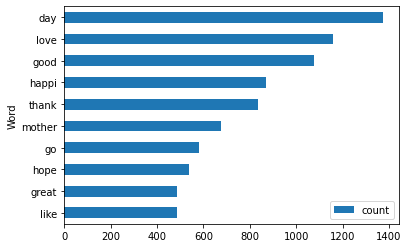

In [260]:
common_words_positive.set_index('Word').sort_values(
    by='count', ascending=True).plot(kind='barh')

In [282]:
import plotly.express as px

px.treemap(common_words_positive, 
           path=['Word'], values='count',
           title='Most commonly used Positive Words',
          width=400, height=400)

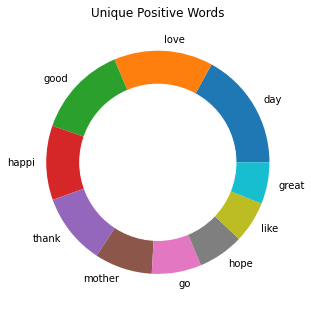

In [278]:
import matplotlib.pyplot as plt
#from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(5,7))
my_circle=plt.Circle((0,0), 0.7, color='white')


plt.pie(common_words_positive['count'], 
        labels=common_words_positive.Word) #,colors=Pastel1_7.hex_colors)

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Positive Words')
plt.show()

### visualization with word cloud

In [319]:
common_words_positive.set_index("Word")['count']

Word
day       1375
love      1160
good      1078
happi      870
thank      834
mother     675
go         581
hope       536
like       487
great      487
Name: count, dtype: int64

In [320]:
words = common_words_positive.set_index("Word")['count'].to_dict()
words

{'day': 1375,
 'love': 1160,
 'good': 1078,
 'happi': 870,
 'thank': 834,
 'mother': 675,
 'go': 581,
 'hope': 536,
 'like': 487,
 'great': 487}

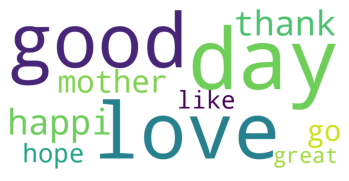

In [330]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=800, height=400)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## negative

In [261]:
common_words_negative  = common_words(negative, 'text processed', 10)
common_words_negative

,Word,count
0,go,737
1,miss,666
2,get,613
3,work,512
4,like,493
5,feel,468
6,sad,453
7,day,436
8,im,369
9,sorri,354


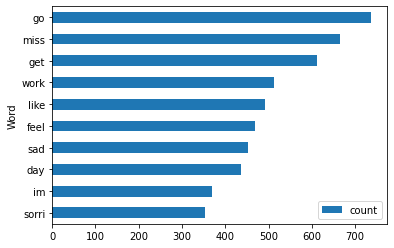

In [262]:
common_words_negative.set_index('Word').sort_values(
    by='count', ascending=True).plot(kind='barh')